In [2]:
import pandas as pd
import numpy as np
import json
import dask.bag as db
import dask.dataframe as dd
import ast
#import tensorflow as tf
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [6]:
df_0409 = dd.read_json('bres_0409.json', blocksize="128 MiB", lines=True)

In [7]:
df1_0409 = df_0409.drop(['level', 'demand_partner', 'opn', 'dbpr', 'dflr', 'kgrp', 'message','bidresponse'], axis=1)
df_raw0409_15 = df1_0409[df1_0409['sflr']== 15.0].drop(['sflr'], axis=1).reset_index(drop=True)

In [8]:
df_raw0409_15  = df_raw0409_15.compute()

In [9]:
df_raw0409_15.to_pickle("df_raw0409_15.pkl")

ArrowInvalid: offset overflow while concatenating arrays

In [3]:
df_raw0409_15 = pd.read_pickle('df_raw0409_15')

FileNotFoundError: [Errno 2] No such file or directory: 'df_raw0409_15'

In [11]:
def extract_features(df_raw):
    list = []
    for i in range(len(df_raw)):
        d1 = {k:v for k,v in json.loads(df_raw.bidrequest.iloc[i]).items() if k not in ['source','at','tmax','user','regs']}
        d2 = {}
        d2['id'] = d1['id']
        if 'minduration' in d1['imp'][0]['video'].keys():
            d2['minduration'] = d1['imp'][0]['video']['minduration']
        else: d2['minduration'] = np.nan
        d2['maxduration'] = d1['imp'][0]['video']['maxduration']
        d2['minbitrate']= d1['imp'][0]['video']['minbitrate']
        d2['maxbitrate']= d1['imp'][0]['video']['maxbitrate']  
        if 'app' in d1.keys():
            if 'id' in d1['app'].keys():
                d2['app_id'] = d1['app']['id']
            else: d2['app_id'] = np.nan
            if 'name' in d1['app'].keys():
                d2['app_name'] = d1['app']['name']
            else: d2['app_name'] = np.nan
            if 'bundle' in d1['app'].keys():
                d2['app_bundle'] = d1['app']['bundle']
            else: d2['app_bundle'] = np.nan
            d2['app_pub_id'] = d1['app']['publisher']['id']
            if 'content' in d1['app'].keys():
                if 'genre' in d1['app']['content'].keys():
                    d2['genre'] = d1['app']['content']['genre']
                else: d2['genre'] = np.nan
                if 'language' in d1['app']['content'].keys():
                    d2['language'] = d1['app']['content']['language']
                else: d2['language'] = np.nan
            else: d2['genre'] = d2['language'] = np.nan
        else: d2['app_id'] = d2['app_bundle']= d2['app_pub_id'] = d2['genre'] = d2['language'] = np.nan
        d2['device_make'] = d1['device']['make']
        if 'model' in d1['device'].keys():
            d2['device_model'] = d1['device']['model']
        else: d2['device_model'] = np.nan
        if 'os' in d1['device'].keys():
            d2['device_os'] = d1['device']['os']
        else: d2['device_os'] = np.nan
        if 'language' in d1['device'].keys():
            d2['device_language'] = d1['device']['language']
        else: d2['device_language'] = np.nan
        if 'geo' in d1['device'].keys() and 'region' in d1['device']['geo'].keys():
            d2['geo_region'] = d1['device']['geo']['region']
        else: d2['geo_region'] = np.nan
        if 'geo' in d1['device'].keys() and 'metro' in d1['device']['geo'].keys():
            d2['geo_metro'] = d1['device']['geo']['metro']
        else: d2['geo_metro'] = np.nan
        list.append(d2)
    df_cl = pd.DataFrame(list)
#    time_df = pd.to_datetime(df_raw.time).dt.tz_localize(None)
#    df_cl = df_cl.assign(time=time_df)
    #df_cl = df_cl.join(sbpr=df_raw.sbpr)
    return df_cl

In [12]:
df_extr0409_15 = extract_features(df_raw0409_15)

In [95]:
def process(df_raw):
    """ 1. input a raw file; output a processed file
    2. extract features from bidrequest
    3. add sbpr and time from the raw file
    4. drop publisher_id and bidrequest columns
    5. add tod column, do not drop time column"""
    def extract_features_row(df_row):
        d1 = {k:v for k,v in json.loads(df_row.bidrequest).items() if k not in ['source','at','tmax','user','regs']}
        d2 = {}
        d2['id'] = d1['id']
        if 'minduration' in d1['imp'][0]['video'].keys():
            d2['minduration'] = d1['imp'][0]['video']['minduration']
        else: d2['minduration'] = np.nan
        d2['maxduration'] = d1['imp'][0]['video']['maxduration']
        d2['minbitrate']= d1['imp'][0]['video']['minbitrate']
        d2['maxbitrate']= d1['imp'][0]['video']['maxbitrate']  
        if 'app' in d1.keys():
            if 'id' in d1['app'].keys():
                d2['app_id'] = d1['app']['id']
            else: d2['app_id'] = np.nan
            if 'name' in d1['app'].keys():
                d2['app_name'] = d1['app']['name']
            else: d2['app_name'] = np.nan
            if 'bundle' in d1['app'].keys():
                d2['app_bundle'] = d1['app']['bundle']
            else: d2['app_bundle'] = np.nan
            d2['app_pub_id'] = d1['app']['publisher']['id']
            if 'content' in d1['app'].keys():
                if 'genre' in d1['app']['content'].keys():
                    d2['genre'] = d1['app']['content']['genre']
                else: d2['genre'] = np.nan
                if 'language' in d1['app']['content'].keys():
                    d2['language'] = d1['app']['content']['language']
                else: d2['language'] = np.nan
            else: d2['genre'] = d2['language'] = np.nan
        else: d2['app_id'] = d2['app_bundle']= d2['app_pub_id'] = d2['genre'] = d2['language'] = np.nan
        d2['device_make'] = d1['device']['make']
        if 'model' in d1['device'].keys():
            d2['device_model'] = d1['device']['model']
        else: d2['device_model'] = np.nan
        if 'os' in d1['device'].keys():
            d2['device_os'] = d1['device']['os']
        else: d2['device_os'] = np.nan
        if 'language' in d1['device'].keys():
            d2['device_language'] = d1['device']['language']
        else: d2['device_language'] = np.nan
        if 'geo' in d1['device'].keys() and 'region' in d1['device']['geo'].keys():
            d2['geo_region'] = d1['device']['geo']['region']
        else: d2['geo_region'] = np.nan
        if 'geo' in d1['device'].keys() and 'metro' in d1['device']['geo'].keys():
            d2['geo_metro'] = d1['device']['geo']['metro']
        else: d2['geo_metro'] = np.nan
        return d2
    applied_df = df_raw.apply(lambda row: extract_features_row(row), axis='columns', result_type='expand')
    df_proc_15 = pd.concat([df_raw, applied_df], axis='columns').drop(['publisher_id', 'bidrequest'], axis=1)
    time_df = pd.to_datetime(df_proc_15.time).dt.tz_localize(None)
    df_proc_15 = df_proc_15.assign(time=time_df)
    new_time = pd.to_datetime(df_proc_15.time, format='%Y-%m-%d %H:%M:%S.%f')
    df_proc_15 = df_proc_15.assign(new_time=new_time)
    df_proc_15['tod'] = pd.cut(df_proc_15.time.dt.hour,
       bins=[0, 6, 12, 18, 24],
       labels=['night', 'morning', 'afternoon', 'evening'],
       right=False,
       include_lowest=True)
    #df_proc_15.drop('time', axis=1, inplace=True)
    # drop device_language as it's always en
    if df_proc_15['device_language'].nunique() == 1:
        df_proc_15.drop('device_language', axis=1, inplace=True)
    # convert all strings to lower case
    for column in df_proc_15.columns:
        if df_proc_15[column].dtype == 'object':
            df_proc_15[column] = df_proc_15[column].str.lower() 
    return df_proc_15

In [96]:
df_extr0409_15 = process(df_raw0409_15)


In [97]:
df_extr0409_15.head(10)

,sbpr,time,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,language,device_make,device_model,device_os,geo_region,geo_metro,new_time,tod
0,15.0,2024-04-09 00:00:01,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,plex,g15147002586,1034,entertainment,NaN,samsung,tizen tv,tizen,sc,546,2024-04-09 00:00:01,night
1,15.0,2024-04-09 00:00:01,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"sling: live tv, shows & movies",com.sling,1034,NaN,NaN,generic,generic android tv,android,oh,NaN,2024-04-09 00:00:01,night
2,15.0,2024-04-09 00:00:02,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,1034,entertainment,NaN,samsung,tizen tv,tizen,tn,691,2024-04-09 00:00:02,night
3,16.5,2024-04-09 00:00:03,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,ga,524,2024-04-09 00:00:03,night
4,15.0,2024-04-09 00:00:03,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,ga,524,2024-04-09 00:00:03,night
5,16.5,2024-04-09 00:00:04,5daa92d5-43c5-478c-b608-0c906248351a,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,fl,NaN,2024-04-09 00:00:04,night
6,15.0,2024-04-09 00:00:04,038f25ab-a500-40a6-a830-36cfa516eebe,1,70,1,280000,711665,xumo,96065,1034,NaN,NaN,roku,digital video player,roku os,tn,640,2024-04-09 00:00:04,night
7,15.0,2024-04-09 00:00:04,6473d65f-5740-4bbb-b126-e06fb365836e,1,70,1,280000,711665,samsungtvplus,g15147002586,1034,NaN,NaN,samsung,tizen tv,tizen,ny,501,2024-04-09 00:00:04,night
8,15.0,2024-04-09 00:00:04,3d5e2791-1e20-423d-bdff-51941e7d100f,1,70,1,280000,711665,samsungtvplus,g15147002586,1034,NaN,NaN,samsung,tizen tv,tizen,ny,501,2024-04-09 00:00:04,night
9,16.5,2024-04-09 00:00:05,29d0ecfa-be16-469f-8cfd-356332f8bac4,1,120,1,280000,711665,"sling: live tv, shows & movies",com.sling,1034,NaN,NaN,nvidia,shield android tv,android,fl,NaN,2024-04-09 00:00:05,night


In [98]:
df_extr0409_15.to_pickle('bres_0409_15_processed.pkl')

In [14]:
df_extr0409_15 = pd.read_pickle('bres_0409_15_processed.pkl')

In [100]:
df_extr0409_15.new_time.dt.hour

0        0
1        0
2        0
3        0
4        0
        ..
6683    23
6684    23
6685    23
6686    23
6687    23
Name: new_time, Length: 1176608, dtype: int32

Now clean the 'om' file, the impressions with successful bids

In [158]:
om_raw = pd.read_json('om_0409.json', lines=True)

In [164]:
om_raw.columns

Index(['level', 'fields', 'time', 'message'], dtype='object')

In [165]:
om_raw.drop(['level', 'time', 'message'], axis=1, inplace=True)

In [167]:
om_raw.loc[0]

fields    {'_om': ['LhYGClQLOAYBGwgmHBdLLB0EQQgKOBcIVAk8...
Name: 0, dtype: object

In [200]:
om_raw.fields[0].keys()

dict_keys(['_om', 'adom', 'adurl', 'apn', 'apr', 'bdid', 'bidts', 'bun', 'chanid', 'country', 'dbpr', 'dflr', 'dmd', 'dom', 'dur', 'dvid', 'exp', 'iab', 'mak', 'mlti', 'opn', 'pubid', 'reg', 'sbpr', 'sflr', 'sup', 'zip'])

In [201]:
def clean_om(row):
    d = {}
    for k,v in row.fields.items():
        if k == 'bdid':
            d[k] = v[0]
        if k == 'sflr':
            d[k] = float(v[0])
        if k == 'sbpr':
            d[k] = float(v[0])
    return d


In [195]:
clean_om(om_raw.loc[1])

{'dvid': 'A4636FBE-8A5C-A152-D709-27C0F4DA3C6E', 'sbpr': 2.0, 'sflr': 2.0}

In [202]:
om_clean_0409 = om_raw.apply(clean_om, axis=1, result_type='expand')

In [203]:
om_clean_0409.head()

,bdid,sbpr,sflr
0,1cca5f27-4ebf-4912-8f74-056f14c7df05,7.5000,5.5
1,7bb13811-7b59-4d0d-ba1d-1941455813c1,2.0000,2.0
2,ecc9b610-52c7-48b4-8d1d-4413efe378af,11.2000,10.0
3,85c980e3-fb1a-469f-8b5a-782731d71832,15.1533,13.0
4,0f8e3f1c-30ca-4e62-bbc8-a18aa54817b3,7.0000,7.0


In [204]:
om_clean_0409.to_pickle('om_clean_0409.pkl')

In [20]:
om_clean_0409 = pd.read_pickle('om_clean_0409.pkl')

In [199]:
len(om_clean_0409)

1776345

In [18]:
bdid_set = set(om_clean_0409[om_clean_0409.sflr == 15.0].bdid)

In [206]:
bdid_set

{'03c2101d-4b96-45bb-b935-cc7d174fd74a',
 '8a04c158-80ec-4dda-add3-21f7be4b8686',
 '0be474e3-89c2-4cf4-b087-8438b8ddbe07',
 'd87eaaab-7ca7-49d7-b389-45a17fa0a4e2',
 '00848e63-ddc5-49be-afcf-884b02e5e38e',
 '2bcae35a-a139-45e6-b060-1b054d9817e5',
 '7091f7ba-1be0-486e-a5c7-1b83c52eca4e',
 'e754acc9-66a4-4c2f-be8c-3067c8034da8',
 'd7dcf377-2ec4-40e0-ac42-e5b66a766a22',
 '639a59cf-ce18-46bd-a335-00e2fa1416d8',
 '36dff71e-b840-4ed5-b812-e1dc434ba2f3',
 '971b5bd9-98fc-41cb-9177-44ecc88c3cb7',
 'c3516c47-0253-4bca-bde9-07a6e01c96e5',
 '5a468c84-af5a-4783-af86-c9ff5ad45f6d',
 '50f2932a-2053-4ec6-b9f2-522b06af9338',
 '0e071f9c-8932-4450-bcb5-5c4f67f6e181',
 '038a7550-3a0a-4245-914c-aa8672025cdb',
 'bd36cf50-7589-4bc9-97c3-78d36404202a',
 '4205bec0-fc98-43ce-aa84-0f82b35228c1',
 '0e9336ef-8ab1-48e3-80b2-8fb320f38cb3',
 '8c6ca99d-9132-4290-b07c-de87cb729a66',
 '60490e02-de85-466f-89ad-92815b53cb65',
 '41aaf6fc-9f9e-42e8-908d-b545ad84f307',
 'd3c2bca0-a7fb-4b8b-a179-d8858eb2e67c',
 '008a47ff-d098-

Function to clean raw om file. Outputs a set of IDs == bdid for a given sflr

In [207]:
def total_clean_om(df_raw, sbpr=15.0):
   df_raw.drop(['level', 'time', 'message'], axis=1, inplace=True) 
   def clean_om(row):
    d = {}
    for k,v in row.fields.items():
        if k == 'bdid':
            d[k] = v[0]
        if k == 'sflr':
            d[k] = float(v[0])
        if k == 'sbpr':
            d[k] = float(v[0])
    return d
    om_clean = df_raw.apply(clean_om, axis=1, result_type='expand')
    bdid_set = set(om_clean[om_clean.sflr == sbpr].bdid)
    return bdid_set
    

In [102]:
df_extr0409_15['data'] = df_extr0409_15.apply(lambda row: row.id in bdid_set, axis=1)
df_extr0409_15.head()

,sbpr,time,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,...,genre,language,device_make,device_model,device_os,geo_region,geo_metro,new_time,tod,data
0,15.0,2024-04-09 00:00:01,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,plex,g15147002586,...,entertainment,NaN,samsung,tizen tv,tizen,sc,546,2024-04-09 00:00:01,night,False
1,15.0,2024-04-09 00:00:01,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"sling: live tv, shows & movies",com.sling,...,NaN,NaN,generic,generic android tv,android,oh,NaN,2024-04-09 00:00:01,night,False
2,15.0,2024-04-09 00:00:02,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,...,entertainment,NaN,samsung,tizen tv,tizen,tn,691,2024-04-09 00:00:02,night,False
3,16.5,2024-04-09 00:00:03,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,...,NaN,en,apple,tv a1625,other,ga,524,2024-04-09 00:00:03,night,False
4,15.0,2024-04-09 00:00:03,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,...,NaN,en,apple,tv a1625,other,ga,524,2024-04-09 00:00:03,night,False


In [103]:
df_extr0409_15.to_pickle('df_extr0409_15YN.pkl')

In [218]:
len(df_extr0409_15[(df_extr0409_15.sbpr==15) & (df_extr0409_15.data == True)])

501051

In [219]:
len(df_extr0409_15[(df_extr0409_15.sbpr==15) & (df_extr0409_15.data == False)])

514624

In [220]:
len(df_extr0409_15[(df_extr0409_15.sbpr != 15) & (df_extr0409_15.data == True)])

76901

In [221]:
len(df_extr0409_15[(df_extr0409_15.sbpr != 15) & (df_extr0409_15.data == False)])

84032

In [92]:
df_extr0409_15['data'] = df_extr0409_15['data'].astype('int8')

In [93]:
ax = df_extr0409_15[(df_extr0409_15.sbpr==15)& (df_extr0409_15.data == True)].hist(column='time', bins=12, color = 'g')
ax = df_extr0409_15[(df_extr0409_15.sbpr==15)& (df_extr0409_15.data == False)].hist(ax=ax, column='time', bins=12, color = 'r')

ValueError: hist method requires numerical or datetime columns, nothing to plot.

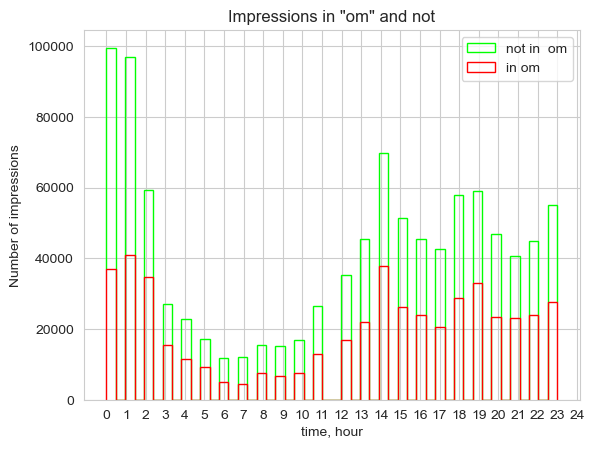

In [108]:
plt.hist([df_extr0409_15[(df_extr0409_15.sbpr==15)& (df_extr0409_15.data == True)].time.dt.hour,df_extr0409_15[(df_extr0409_15.sbpr==15)& (df_extr0409_15.data == False)].time.dt.hour], histtype='step', stacked=True, fill=False, bins = 48, color = ['red', 'lime'],  label = ['in om', 'not in  om'])
plt.legend(loc = 'best')
plt.xlabel('time, hour')
plt.xticks(range(25))
plt.ylabel('Number of impressions')
plt.title('Impressions in "om" and not')
plt.show()

start cleaning categories

In [222]:
df_extr0409_15.language = df_extr0409_15.language.str.lower().str.replace('-', "_").str.replace('\[[^\]]*\]', 'NaN', regex=True).replace('NaN', np.nan)
df_extr0409_15.language.unique()

array([nan, 'en', 'es', 'english', 'en_us', 'ru', 'zh', 'ko',
       'english, japanese', 'mandarin, cantonese, english', 'th', 'ja',
       'japanese', 'yue'], dtype=object)

In [223]:
df_extr0409_15.language.value_counts(normalize=True)

language
en                              0.996388
es                              0.002437
english                         0.000753
zh                              0.000191
en_us                           0.000177
ko                              0.000025
ja                              0.000012
th                              0.000007
mandarin, cantonese, english    0.000003
yue                             0.000003
ru                              0.000001
english, japanese               0.000001
japanese                        0.000001
Name: proportion, dtype: float64

In [224]:
df_extr0409_15.drop('language', axis=1, inplace=True)

In [225]:
df_extr0409_15.app_id.value_counts(normalize=True)

app_id
711667    5.000076e-01
711665    3.807649e-01
726329    4.550793e-02
635564    2.262096e-02
623265    7.431532e-03
              ...     
723588    8.499007e-07
678654    8.499007e-07
709722    8.499007e-07
659536    8.499007e-07
625512    8.499007e-07
Name: proportion, Length: 411, dtype: float64

In [226]:
def clean_app_id(df, cut_off=0.01):
    ids = df.app_id.value_counts(normalize=True) >= cut_off
    labels = ids[ids].index
    def clean_app_id(row,labels):
        if row in labels:
            return row
        else: 
            return 'other_id'
    df.app_id = df.app_id.apply(clean_app_id, args = (labels,))
    return df

In [227]:
clean_app_id(df_extr0409_15)

,sbpr,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,device_make,device_model,device_os,geo_region,geo_metro,tod,data
0,15.000000,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,other_id,plex,g15147002586,1034,entertainment,samsung,tizen tv,tizen,sc,546,night,False
1,15.000000,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"sling: live tv, shows & movies",com.sling,1034,NaN,generic,generic android tv,android,oh,NaN,night,False
2,15.000000,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,1034,entertainment,samsung,tizen tv,tizen,tn,691,night,False
3,16.500000,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,apple,tv a1625,other,ga,524,night,False
4,15.000000,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,apple,tv a1625,other,ga,524,night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,15.000000,2ac8cea8-7284-4649-adb1-572cb89e5142,1,70,1,280000,711667,fubotv,b019dchdzk,1034,NaN,unknown,aftmm,fire os,nj,501,evening,False
6684,15.220674,4094145f-1bcb-46e5-8f14-6f26ab8a1fdd,1,120,1,280000,711665,plex,383457673,1034,NaN,apple,tv a1625,other,tx,623,evening,False
6685,15.600000,1d33c229-9c0c-4efd-ad20-c609d486a78e,1,70,1,280000,711665,fubotv,b019dchdzk,1034,NaN,amazon,aftsss,fire os,hi,744,evening,False
6686,15.000000,77df0a7c-89a8-4327-b27f-f535483741b3,1,70,1,280000,711667,fubotv,b019dchdzk,1034,NaN,amazon,aftt,fire os,nc,NaN,evening,True


In [228]:
df_extr0409_15.app_name.value_counts(normalize=True)

app_name
fubotv                            2.272347e-01
plex                              1.451037e-01
xumo                              1.183439e-01
fubotv: watch live sports & tv    1.171903e-01
sling: live tv, shows & movies    9.651820e-02
                                      ...     
wzmq 19                           8.501110e-07
21 alive news                     8.501110e-07
23 news to go                     8.501110e-07
abc-7 kvia.com                    8.501110e-07
wrdw news 12 | wagt nbc 26        8.501110e-07
Name: proportion, Length: 233, dtype: float64

In [229]:
def clean_app_name(row):
    if type(row) == float:
        return 'other_name'
    if 'fubo' in row:
        return 'fubo'
    if 'xumo' in row:
        return 'xumo'
    if 'news' in row:
        return 'news'
    if 'sling' in row:
        return 'sling'
    if 'samsung' in row:
        return 'samsung tv'
    if 'fox' in row:
        return 'fox tv'
    if 'pluto' in row: 
        return 'pluto tv'
    if 'weather' in row:
        return 'weather tv'
    if 'plex' in row:
        return 'plex'
    if 'cbs' in row:
        return 'cbs tv'
    if 'lg' in row :
        return 'lg tv'
    if 'wisc' in row:
        return 'wisc tv'
    if 'stirr' in row:
        return 'stirr tv'
    if 'kavu' in row:
        return 'kavu tv'
    if 'frndly' in row:
        return 'frndly tv'
    if 'live' in row:
        return 'live tv'
    if 'wlbt' in row:
        return 'wlbt tv'
    if 'lg' in row:
        return 'lg tv'
    if 'wafb' in row:
        return 'wafb tv'
    if 'wfsb' in row:
        return 'wfsb tv'
    if 'wabi' in row:
        return 'wabi tv'
    else: return row

In [230]:
df_extr0409_15.app_name = df_extr0409_15.app_name.apply(clean_app_name)

In [231]:
bun_val = df_extr0409_15.app_bundle.value_counts(normalize=True)
bun_val

app_bundle
b019dchdzk      2.240157e-01
96065           1.236549e-01
905401434       1.177113e-01
g15147002586    1.093454e-01
com.sling       1.021423e-01
                    ...     
b06y4z1l62      8.499318e-07
449395459       8.499318e-07
420526286       8.499318e-07
699789          8.499318e-07
b00v3utycg      8.499318e-07
Name: proportion, Length: 319, dtype: float64

In [233]:
def app_bundle_clean(df, cut_off=0.01):
    ids = df.app_bundle.value_counts(normalize=True) >= cut_off
    labels = ids[ids].index
    def clean_app_bundle(row,labels):
        if row in labels:
            return row
        else: 
            return 'other_bundle'
    df.app_bundle = df.app_bundle.apply(clean_app_bundle, args = (labels,))
    return df

In [234]:
app_bundle_clean(df_extr0409_15)

,sbpr,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,device_make,device_model,device_os,geo_region,geo_metro,tod,data
0,15.000000,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,other_id,plex,g15147002586,1034,entertainment,samsung,tizen tv,tizen,sc,546,night,False
1,15.000000,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,sling,com.sling,1034,NaN,generic,generic android tv,android,oh,NaN,night,False
2,15.000000,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,1034,entertainment,samsung,tizen tv,tizen,tn,691,night,False
3,16.500000,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubo,905401434,1034,NaN,apple,tv a1625,other,ga,524,night,False
4,15.000000,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubo,905401434,1034,NaN,apple,tv a1625,other,ga,524,night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,15.000000,2ac8cea8-7284-4649-adb1-572cb89e5142,1,70,1,280000,711667,fubo,b019dchdzk,1034,NaN,unknown,aftmm,fire os,nj,501,evening,False
6684,15.220674,4094145f-1bcb-46e5-8f14-6f26ab8a1fdd,1,120,1,280000,711665,plex,383457673,1034,NaN,apple,tv a1625,other,tx,623,evening,False
6685,15.600000,1d33c229-9c0c-4efd-ad20-c609d486a78e,1,70,1,280000,711665,fubo,b019dchdzk,1034,NaN,amazon,aftsss,fire os,hi,744,evening,False
6686,15.000000,77df0a7c-89a8-4327-b27f-f535483741b3,1,70,1,280000,711667,fubo,b019dchdzk,1034,NaN,amazon,aftt,fire os,nc,NaN,evening,True


In [236]:
app_pub = df_extr0409_15.app_pub_id.value_counts(normalize=True)
app_pub

app_pub_id
1034    0.934937
1024    0.026277
1077    0.016351
1043    0.010268
1112    0.007813
1009    0.002716
1261    0.001565
1109    0.000059
1270    0.000014
Name: proportion, dtype: float64

In [237]:
def app_pub_clean(df, cut_off=0.001):
    ids = df.app_pub_id.value_counts(normalize=True) >= cut_off
    labels = ids[ids].index
    def clean_app_pub(row,labels):
        if row in labels:
            return row
        else: 
            return 'other_pub_id'
    df.app_pub_id = df.app_pub_id.apply(clean_app_pub, args = (labels,))
    return df

In [238]:
app_bundle_clean(df_extr0409_15)

,sbpr,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,device_make,device_model,device_os,geo_region,geo_metro,tod,data
0,15.000000,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,other_id,plex,g15147002586,1034,entertainment,samsung,tizen tv,tizen,sc,546,night,False
1,15.000000,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,sling,com.sling,1034,NaN,generic,generic android tv,android,oh,NaN,night,False
2,15.000000,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,1034,entertainment,samsung,tizen tv,tizen,tn,691,night,False
3,16.500000,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubo,905401434,1034,NaN,apple,tv a1625,other,ga,524,night,False
4,15.000000,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubo,905401434,1034,NaN,apple,tv a1625,other,ga,524,night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,15.000000,2ac8cea8-7284-4649-adb1-572cb89e5142,1,70,1,280000,711667,fubo,b019dchdzk,1034,NaN,unknown,aftmm,fire os,nj,501,evening,False
6684,15.220674,4094145f-1bcb-46e5-8f14-6f26ab8a1fdd,1,120,1,280000,711665,plex,383457673,1034,NaN,apple,tv a1625,other,tx,623,evening,False
6685,15.600000,1d33c229-9c0c-4efd-ad20-c609d486a78e,1,70,1,280000,711665,fubo,b019dchdzk,1034,NaN,amazon,aftsss,fire os,hi,744,evening,False
6686,15.000000,77df0a7c-89a8-4327-b27f-f535483741b3,1,70,1,280000,711667,fubo,b019dchdzk,1034,NaN,amazon,aftt,fire os,nc,NaN,evening,True


In [239]:
df_extr0409_15.genre.value_counts(normalize=True)

genre
news                                                    0.266181
home and garden,arts,documentary                        0.079191
entertainment                                           0.061116
weather                                                 0.041592
action                                                  0.039671
                                                          ...   
medical                                                 0.000008
outdoors,preview,sports_stuff                           0.000008
comedy,romance,drama,comedy_drama                       0.000008
genre_thriller,genre_crime,genre_drama,genre_mystery    0.000008
other,drama,suspense_thriller                           0.000008
Name: proportion, Length: 1310, dtype: float64

In [240]:
def cleanup_genre(row):
    if type(row) == float: return 'other_genre'
    if 'news' in row: return 'news'
    if 'talk' in row: return 'talk'
    if 'home' in row: return 'home'
    if 'documentary' in row: return 'documentary'
    if 'weather' in row: return 'weather'
    if 'comedy' in row: return 'comedy'
    if 'action' in row: return 'action'
    if 'sitcom' in row: return 'sitcom'
    if 'my city' in row: return 'my city'
    if 'drama' in row: return 'drama'
    else: return 'other_genre'

In [241]:
df_extr0409_15.genre = df_extr0409_15.genre.apply(cleanup_genre)

In [242]:
df_extr0409_15.device_make.value_counts(normalize=True)

device_make
roku                        2.072381e-01
samsung                     1.905605e-01
amazon                      1.679497e-01
apple                       1.448554e-01
unknown                     8.241827e-02
                                ...     
hkc                         8.499007e-07
6.3.9                       8.499007e-07
hikeen_siliconplayer_rca    8.499007e-07
toshiba (vidaa)             8.499007e-07
arris                       8.499007e-07
Name: proportion, Length: 82, dtype: float64

In [243]:
def device_clean(df):
    def cleanup_device(row):
        if 'samsung' in row: return 'samsung'
        if 'apple' in row: return 'apple'
        if 'roku' in row: return 'roku'
        if 'amazon' in row: return 'amazon' 
        if 'xiaomi' in row: return 'xiaomi'
        if 'lg' in row: return 'lg'
        if 'tcl' in row: return 'tcl'
        if 'vizio' in row: return 'vizio'
        if 'generic' in row: return 'generic'
        if 'insignia' in row: return 'insignia'
        if 'sony' in row: return 'sony'
        if 'toshiba' in row: return 'toshiba'
        else: return 'device_unknown'
    df.device_make = df.device_make.apply(cleanup_device)
    return df

In [244]:
device_clean(df_extr0409_15)

,sbpr,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,device_make,device_model,device_os,geo_region,geo_metro,tod,data
0,15.000000,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,other_id,plex,g15147002586,1034,other_genre,samsung,tizen tv,tizen,sc,546,night,False
1,15.000000,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,sling,com.sling,1034,other_genre,generic,generic android tv,android,oh,NaN,night,False
2,15.000000,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,1034,other_genre,samsung,tizen tv,tizen,tn,691,night,False
3,16.500000,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubo,905401434,1034,other_genre,apple,tv a1625,other,ga,524,night,False
4,15.000000,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubo,905401434,1034,other_genre,apple,tv a1625,other,ga,524,night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,15.000000,2ac8cea8-7284-4649-adb1-572cb89e5142,1,70,1,280000,711667,fubo,b019dchdzk,1034,other_genre,device_unknown,aftmm,fire os,nj,501,evening,False
6684,15.220674,4094145f-1bcb-46e5-8f14-6f26ab8a1fdd,1,120,1,280000,711665,plex,383457673,1034,other_genre,apple,tv a1625,other,tx,623,evening,False
6685,15.600000,1d33c229-9c0c-4efd-ad20-c609d486a78e,1,70,1,280000,711665,fubo,b019dchdzk,1034,other_genre,amazon,aftsss,fire os,hi,744,evening,False
6686,15.000000,77df0a7c-89a8-4327-b27f-f535483741b3,1,70,1,280000,711667,fubo,b019dchdzk,1034,other_genre,amazon,aftt,fire os,nc,NaN,evening,True


In [245]:
df_extr0409_15.device_model.value_counts(normalize=True)

device_model
digital video player    1.738064e-01
tizen tv                1.696504e-01
tv a1625                1.248394e-01
aftmm                   8.433650e-02
aftsss                  5.901031e-02
                            ...     
un43ru7200fxza          8.499007e-07
e80-e3                  8.499007e-07
55a53fevs_0008          8.499007e-07
t-msmakuc-1420.0        8.499007e-07
un60ku6270              8.499007e-07
Name: proportion, Length: 838, dtype: float64

In [246]:
def device_model_clean(df, model_cut_off=0.001):
    ids = df.device_model.value_counts(normalize=True) >= model_cut_off
    labels = ids[ids].index
    def clean_device_model(row,labels):
        if row in labels:
            return row
        else: 
            return 'other_device_model'
    df.app_pub_id = df.app_pub_id.apply(clean_device_model, args = (labels,))
    return df

In [247]:
device_model_clean(df_extr0409_15)

,sbpr,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,device_make,device_model,device_os,geo_region,geo_metro,tod,data
0,15.000000,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,other_id,plex,g15147002586,other_device_model,other_genre,samsung,tizen tv,tizen,sc,546,night,False
1,15.000000,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,sling,com.sling,other_device_model,other_genre,generic,generic android tv,android,oh,NaN,night,False
2,15.000000,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,other_device_model,other_genre,samsung,tizen tv,tizen,tn,691,night,False
3,16.500000,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubo,905401434,other_device_model,other_genre,apple,tv a1625,other,ga,524,night,False
4,15.000000,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubo,905401434,other_device_model,other_genre,apple,tv a1625,other,ga,524,night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,15.000000,2ac8cea8-7284-4649-adb1-572cb89e5142,1,70,1,280000,711667,fubo,b019dchdzk,other_device_model,other_genre,device_unknown,aftmm,fire os,nj,501,evening,False
6684,15.220674,4094145f-1bcb-46e5-8f14-6f26ab8a1fdd,1,120,1,280000,711665,plex,383457673,other_device_model,other_genre,apple,tv a1625,other,tx,623,evening,False
6685,15.600000,1d33c229-9c0c-4efd-ad20-c609d486a78e,1,70,1,280000,711665,fubo,b019dchdzk,other_device_model,other_genre,amazon,aftsss,fire os,hi,744,evening,False
6686,15.000000,77df0a7c-89a8-4327-b27f-f535483741b3,1,70,1,280000,711667,fubo,b019dchdzk,other_device_model,other_genre,amazon,aftt,fire os,nc,NaN,evening,True


In [248]:
df_extr0409_15.isnull().any()

sbpr            False
id              False
minduration     False
maxduration     False
minbitrate      False
maxbitrate      False
app_id          False
app_name        False
app_bundle      False
app_pub_id      False
genre           False
device_make     False
device_model    False
device_os       False
geo_region       True
geo_metro        True
tod             False
data            False
dtype: bool

In [249]:
def geo_region_clean(df):
    def clean_region(row):
        if type(row) == float:
            return 'other_region'
        else: return row
    df.geo_region = df.geo_region.apply(clean_region)
    return df

In [250]:
geo_region_clean(df_extr0409_15)

,sbpr,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,device_make,device_model,device_os,geo_region,geo_metro,tod,data
0,15.000000,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,other_id,plex,g15147002586,other_device_model,other_genre,samsung,tizen tv,tizen,sc,546,night,False
1,15.000000,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,sling,com.sling,other_device_model,other_genre,generic,generic android tv,android,oh,NaN,night,False
2,15.000000,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,other_device_model,other_genre,samsung,tizen tv,tizen,tn,691,night,False
3,16.500000,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubo,905401434,other_device_model,other_genre,apple,tv a1625,other,ga,524,night,False
4,15.000000,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubo,905401434,other_device_model,other_genre,apple,tv a1625,other,ga,524,night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,15.000000,2ac8cea8-7284-4649-adb1-572cb89e5142,1,70,1,280000,711667,fubo,b019dchdzk,other_device_model,other_genre,device_unknown,aftmm,fire os,nj,501,evening,False
6684,15.220674,4094145f-1bcb-46e5-8f14-6f26ab8a1fdd,1,120,1,280000,711665,plex,383457673,other_device_model,other_genre,apple,tv a1625,other,tx,623,evening,False
6685,15.600000,1d33c229-9c0c-4efd-ad20-c609d486a78e,1,70,1,280000,711665,fubo,b019dchdzk,other_device_model,other_genre,amazon,aftsss,fire os,hi,744,evening,False
6686,15.000000,77df0a7c-89a8-4327-b27f-f535483741b3,1,70,1,280000,711667,fubo,b019dchdzk,other_device_model,other_genre,amazon,aftt,fire os,nc,NaN,evening,True


In [251]:
df_extr0409_15.geo_metro.value_counts(normalize=True)

geo_metro
501    0.100693
602    0.053127
528    0.048700
623    0.045657
524    0.038776
         ...   
976    0.000001
946    0.000001
928    0.000001
966    0.000001
927    0.000001
Name: proportion, Length: 230, dtype: float64

In [256]:
def geo_metro_clean(df):
    def clean_metro(row):
        if type(row) == float:
            return 'other_metro'
        else: return row
    df.geo_metro = df.geo_metro.apply(clean_metro)
    return df

In [257]:
geo_metro_clean(df_extr0409_15)

,sbpr,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,device_make,device_model,device_os,geo_region,geo_metro,tod,data
0,15.000000,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,other_id,plex,g15147002586,other_device_model,other_genre,samsung,tizen tv,tizen,sc,546,night,False
1,15.000000,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,sling,com.sling,other_device_model,other_genre,generic,generic android tv,android,oh,other_metro,night,False
2,15.000000,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,other_device_model,other_genre,samsung,tizen tv,tizen,tn,691,night,False
3,16.500000,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubo,905401434,other_device_model,other_genre,apple,tv a1625,other,ga,524,night,False
4,15.000000,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubo,905401434,other_device_model,other_genre,apple,tv a1625,other,ga,524,night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6683,15.000000,2ac8cea8-7284-4649-adb1-572cb89e5142,1,70,1,280000,711667,fubo,b019dchdzk,other_device_model,other_genre,device_unknown,aftmm,fire os,nj,501,evening,False
6684,15.220674,4094145f-1bcb-46e5-8f14-6f26ab8a1fdd,1,120,1,280000,711665,plex,383457673,other_device_model,other_genre,apple,tv a1625,other,tx,623,evening,False
6685,15.600000,1d33c229-9c0c-4efd-ad20-c609d486a78e,1,70,1,280000,711665,fubo,b019dchdzk,other_device_model,other_genre,amazon,aftsss,fire os,hi,744,evening,False
6686,15.000000,77df0a7c-89a8-4327-b27f-f535483741b3,1,70,1,280000,711667,fubo,b019dchdzk,other_device_model,other_genre,amazon,aftt,fire os,nc,other_metro,evening,True


In [258]:
df_extr0409_15.isnull().any()

sbpr            False
id              False
minduration     False
maxduration     False
minbitrate      False
maxbitrate      False
app_id          False
app_name        False
app_bundle      False
app_pub_id      False
genre           False
device_make     False
device_model    False
device_os       False
geo_region      False
geo_metro       False
tod             False
data            False
dtype: bool

In [314]:
df_extr0409_15.sbpr = df_extr0409_15.sbpr.apply(round, args=(2,))

In [315]:
df_extr0409_15.to_pickle('df_0409_15_ready.pkl') # this is a totally cleaned/reduced bres file labelled with Y/N, that is whether the impression is in om as well.

In [2]:
df_extr0409_15 = pd.read_pickle('df_0409_15_ready.pkl')

In [3]:
df_extr0409_15.columns

Index(['sbpr', 'id', 'minduration', 'maxduration', 'minbitrate', 'maxbitrate',
       'app_id', 'app_name', 'app_bundle', 'app_pub_id', 'genre',
       'device_make', 'device_model', 'device_os', 'geo_region', 'geo_metro',
       'tod', 'data'],
      dtype='object')

In [3]:
one_hot_1 = pd.get_dummies(df_extr0409_15[['minduration', 'maxduration', 'minbitrate', 'maxbitrate','app_id','app_name','app_bundle',
 'app_pub_id', 'genre', 'device_make', 'device_model','device_os','geo_region','geo_metro','tod']],drop_first=False)

since one-hot-encoded data is missing sbpr and Y/N attach it back

In [4]:
one_hot_data = pd.concat([one_hot_1,df_extr0409_15[['sbpr', 'data']]], axis=1)

now split into training (sbpr == 15) and the one to be predicted (sbpr != 15)

In [5]:
df_train_all = one_hot_data[one_hot_data.sbpr == 15.0]

In [6]:
train_b, test_b = train_test_split(df_train_all, test_size=0.2)
train_data_b, train_label_b = train_b.iloc[:, :-2], train_b.iloc[:, [-1]]
test_data_b, test_label_b = test_b.iloc[:, :-2], test_b.iloc[:, [-1]]

In [320]:
tree_b = DecisionTreeClassifier(criterion='entropy')
tree_fit_b = tree_b.fit(train_data_b, train_label_b)

In [321]:
pred_b = tree_fit_b.predict(test_data_b)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(test_label_b, pred_b)))

Model accuracy score: 0.6684


In [322]:
pred_a = tree_fit_b.predict(train_data_b)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(train_label_b, pred_a)))

Model accuracy score: 0.7053


In [323]:
print(tree_b.tree_.max_depth)

166


In [269]:
def run_trees():
    # to be changed - needs to output a dictionary so that I can find optimal, need to add train test accuracy as well tto compare
    for criterion in ['gini', 'entropy']:
        for max_depth in range(75, 165, 20):
            for min_samples_split in range(2,6,2):
                for min_samples_leaf in range(2,5):
                    tree_b = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                    tree_fit_b = tree_b.fit(train_data_b, train_label_b)
                    pred_b = tree_fit_b.predict(test_data_b)
                    acc = accuracy_score(test_label_b, pred_b)
                    print(f'Model {criterion} with accuracy score: {acc:.4f}, Max depth: {max_depth}, Min depth: {min_samples_split}, Min samples: {min_samples_leaf}')

In [270]:
run_trees()

Model gini with accuracy score: 0.6649, Max depth: 75, Min depth: 2, Min samples: 2
Model gini with accuracy score: 0.6645, Max depth: 75, Min depth: 2, Min samples: 3
Model gini with accuracy score: 0.6637, Max depth: 75, Min depth: 2, Min samples: 4


KeyboardInterrupt: 

do the prediction

In [324]:
df_predict_all = one_hot_data[one_hot_data.sbpr > 15.0]

In [325]:
to_predict_data = df_predict_all.iloc[:,:-2]

In [326]:
real_pred_b = tree_fit_b.predict(to_predict_data)

In [327]:
# these are the columns that matter below. Will use sbpr > 15 to select those for which the prediction has been made; will use data to select those that are in om
df_prel = df_extr0409_15[['sbpr', 'data']]

In [328]:
df_m = df_prel[df_prel.sbpr > 15.0]
df_m.reset_index(inplace=True, drop=True)
df_m.head()

,sbpr,data
0,16.50,False
1,16.50,False
2,16.50,False
3,15.60,False
4,16.77,False


In [329]:
#create a df from predictions np array
df_pred_b = pd.DataFrame(real_pred_b, columns=["pred"])
df_pred_b.head()

,pred
0,False
1,False
2,False
3,False
4,False


In [330]:
df_matters = pd.concat([df_m, df_pred_b], axis=1)
df_matters.head()

,sbpr,data,pred
0,16.50,False,False
1,16.50,False,False
2,16.50,False,False
3,15.60,False,False
4,16.77,False,False


In [331]:
df_all_bres = pd.DataFrame(df_matters.groupby(['sbpr'])['sbpr'].count())
df_all_bres=df_all_bres.rename(columns={"sbpr":"total_cnt"})
df_all_bres.head(10)

,total_cnt
sbpr,
15.01,2137
15.02,218
15.03,12
15.04,7
15.05,19
15.06,12
15.07,9
15.08,49
15.09,20


In [332]:
df_all_om = pd.DataFrame(df_matters[df_matters.data==True].groupby(['sbpr'])['sbpr'].count()) # weeding out those that are not in om
df_all_om=df_all_om.rename(columns={"sbpr":"om_cnt"})
df_all_om.head()

,om_cnt
sbpr,
15.01,1041
15.02,23
15.03,4
15.04,1
15.05,10


In [333]:
prob_1 = df_all_om.join(df_all_bres, on='sbpr', how="left")
prob_2 = prob_1[prob_1.om_cnt>100] # eliminate low count data points

In [334]:
prob_2["prob_before"] = prob_2.om_cnt/prob_2.total_cnt


/var/folders/kx/b_1b_kg17090wwlbwz4s8m940000gn/T/ipykernel_67232/1477795586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prob_2["prob_before"] = prob_2.om_cnt/prob_2.total_cnt


In [344]:
prob_2 = prob_2.reset_index()
prob_2.head()

,sbpr,om_cnt,total_cnt,prob_before
0,15.01,1041,2137,0.487131
1,15.10,242,366,0.661202
2,15.17,909,3027,0.300297
3,15.38,2396,5453,0.439391
4,15.52,946,3063,0.308848


In [335]:
# now weed out those data points which the prediction shows should be at sbpr == 15
df_clean = df_matters[df_matters.pred==False]

In [336]:
df_bres_after = pd.DataFrame(df_clean.groupby(['sbpr'])['sbpr'].count())
df_bres_after=df_bres_after.rename(columns={"sbpr":"total_cnt"})
df_bres_after.head()

,total_cnt
sbpr,
15.01,1089
15.02,175
15.03,8
15.04,7
15.05,10


In [338]:
df_om_after = pd.DataFrame(df_clean[df_clean.data==True].groupby(['sbpr'])['sbpr'].count())
df_om_after = df_om_after.rename(columns={"sbpr":"om_cnt"})

In [339]:
prob_1_after = df_om_after.join(df_bres_after, on='sbpr', how="left")
prob_2_after = prob_1_after[prob_1_after.om_cnt>100]
prob_2_after.head()

,om_cnt,total_cnt
sbpr,,
15.01,390,1089
15.10,152,228
15.17,455,2141
15.38,959,3156
15.52,466,2151


In [342]:
prob_2_after["prob_after"] = prob_2_after.om_cnt/prob_2_after.total_cnt
prob_2_after = prob_2_after.reset_index()

Text(0, 0.5, 'Probability')

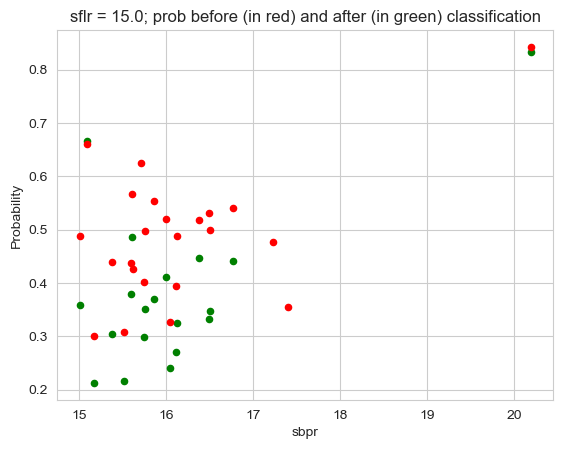

In [345]:
ax = prob_2_after.plot(kind='scatter', x='sbpr', y='prob_after', color='g') #, title=f'sflr = 15.0 vs prob after'
ax = prob_2.plot(ax=ax, kind='scatter', x='sbpr', y='prob_before', color='r', title=f'sflr = 15.0; prob before (in red) and after (in green) classification')
ax.set_ylabel("Probability")

<Axes: title={'center': 'sflr = 15.0 vs prob after'}, xlabel='sbpr', ylabel='prob_after'>

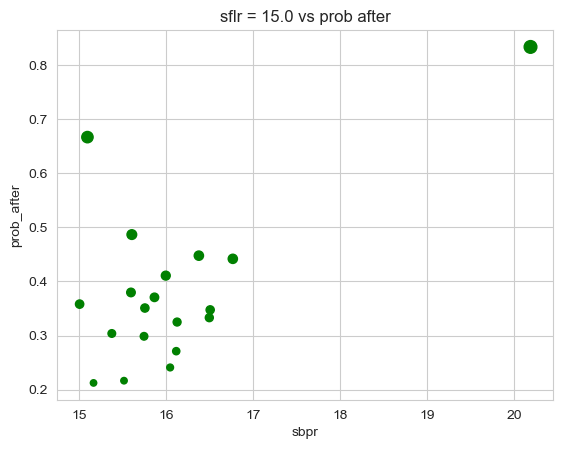

In [346]:
prob_2_after.plot(kind='scatter', x='sbpr', y='prob_after', color='g', s = prob_2_after.prob_after*100 , title=f'sflr = 15.0 vs prob after')

In [349]:
prob_2_after.head(20)

,index,sbpr,om_cnt,total_cnt,prob_after
0,0,15.01,390,1089,0.358127
1,1,15.10,152,228,0.666667
2,2,15.17,455,2141,0.212518
3,3,15.38,959,3156,0.303866
4,4,15.52,466,2151,0.216643
5,5,15.60,10004,26349,0.379673
6,6,15.61,363,746,0.486595
7,7,15.75,597,1999,0.298649
8,8,15.76,313,892,0.350897
9,9,15.87,1602,4322,0.370662


Random Forest

In [9]:
rfc = RandomForestClassifier(n_estimators = 50, random_state = 42)
# accuracies = cross_val_score(rfc, train_data_b, train_label_b.values.ravel(), cv=5)
rfc.fit(train_data_b, train_label_b.values.ravel())


RandomForestClassifier(n_estimators=50, random_state=42)

In [15]:
train_label_b.values.ravel().shape

(812765,)

In [19]:
train_data_b.shape

(812765, 1273)

In [10]:
y_pred = rfc.predict(test_data_b)
 
#Obtain accuracy
# print("Train Score:",np.mean(accuracies))
# print("Test Score:",rfc.score(test_data_b, test_label_b ))

In [23]:
y_pred[:10]

array([False, False,  True,  True,  True,  True, False, False, False,
        True])

In [11]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(test_label_b,y_pred)))

Model accuracy score: 0.6708


In [30]:
print("Test Score:",rfc.score(test_data_b, test_label_b ))

Test Score: 0.6692438678688137


In [ ]:
svc = SVC(random_state = 42)
#accuracies = cross_val_score(svc,train_data_b, train_label_b.values.ravel(), cv=5)
svc.fit(train_data_b, train_label_b.values.ravel())


In [ ]:
y_pred_svc = svc.predict(test_data_b)
 
#Obtain accuracy
# print("Train Score:",np.mean(accuracies))
# print("Test Score:",svc.score(X_test,y_test_svc))
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(test_label_b,y_pred_svc)))

In [18]:
sgdc = SGDClassifier(max_iter=100, early_stopping=True, random_state=1)

In [19]:
sgdc.fit(train_data_b, train_label_b.values.ravel())


SGDClassifier(early_stopping=True, max_iter=100, random_state=1)

In [20]:
y_pred_gd = sgdc.predict(test_data_b)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(test_label_b,y_pred_gd)))

Model accuracy score: 0.5061


In [7]:
knn = KNeighborsClassifier()
knn.fit(train_data_b, train_label_b.values.ravel())

KNeighborsClassifier()

In [8]:
y_pred_knn = knn.predict(test_data_b)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(test_label_b,y_pred_knn)))

Model accuracy score: 0.6364


In [9]:
knnd = KNeighborsClassifier(algorithm="kd_tree", n_neighbors=5)
knnd.fit(train_data_b, train_label_b.values.ravel())

KNeighborsClassifier(algorithm='kd_tree')

In [10]:
y_pred_knnd = knnd.predict(test_data_b)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(test_label_b,y_pred_knnd)))

Model accuracy score: 0.6361
